In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import robustness_model

In [2]:
def gen_datapoints(original_dim, mean1, mean2, std1, std2):
    
    X1 = torch.empty(10, original_dim).normal_(mean=mean1,std=std1)
    X2 = torch.empty(10, original_dim).normal_(mean=mean2,std=std2)

    X = torch.concatenate((X1, X2), dim=0)
    y = torch.tensor([0 for _ in range(len(X1))] + [1 for _ in range(len(X2))])

    return X, y


def get_eps(model, q, L):
    phi_diff = model.class_hvs1 - model.class_hvs2
    phi_q = model.encoder(q.reshape(1, -1))
    r_q = model.encoder.inner(phi_diff.reshape(1, -1), phi_q)[0, 0]
    return torch.abs(r_q) / L


def sat_cond_within_radius(x_ctr, r, xy, zs, cond):
    d, N, M = xy.shape
    x_aug = np.tile(x_ctr, (M, N, 1)).T
    dists = np.linalg.norm(xy - x_aug, axis=0)
    return np.all(cond(zs[dists <= r]))


def get_actual_eps(encoder, phi_c1, phi_c2, x_ctr, x_grid, y_grid, zs, init_r=1, threshold=100, tol=1e-4):
    phi_x = encoder(x_ctr.reshape(1, -1))[0]
    r_x = (phi_c1 - phi_c2).numpy() @ phi_x.numpy()
    
    if r_x >= 0:
        cond = lambda x: x >= 0
    else:
        cond = lambda x: x < 0
    
    xy = np.stack([x_grid, y_grid])
    r_l = 0
    r_h = init_r
    for _ in range(threshold):
        if sat_cond_within_radius(x_ctr.numpy(), r_h, xy, zs.numpy(), cond):
            r_l, r_h = r_h, r_h * 2
        else:
            r_h = r_l + (r_h - r_l) / 2
        if r_h - r_l <= tol:
            break
    return r_h


def plot_2d_epsilon(model, X, y, title=''):

    X1, X2 = X[y == 0], X[y == 1]

    vmins, vmaxs = X.min(axis=0)[0] - 5, X.max(axis=0)[0] + 5
    
    grids = torch.meshgrid(*[torch.linspace(vmin, vmax, 100) for vmin, vmax in zip(vmins, vmaxs)], indexing='ij')
    qs = torch.stack([grid.reshape(-1) for grid in grids], axis=1)
    qs_enc = model.encoder(qs)
    sims = torch.tensor([model.encoder.inner(phi_q.reshape(1, -1), (model.class_hvs1 - model.class_hvs2).reshape(1, -1)) for phi_q in qs_enc])

    ds = []
    es1 = []
    es2_r2 = []
    es2_r5 = []
    es3 = []

    for q, y_ in zip(X, y):

        d = get_actual_eps(model.encoder, model.class_hvs1, model.class_hvs2, q, grids[0], grids[1], sims.reshape(len(grids[0]), -1))

        L1 = model.get_linear_approximation(q)
        L2_r2 = model.get_conservative_lipschitz_constant(q)
        L2_r5 = model.get_conservative_lipschitz_constant(q, r=5)
        L3 = model.get_lipschitz_constant()

        e1 = get_eps(model, q, L1)
        e2_r2 = get_eps(model, q, L2_r2)
        e2_r5 = get_eps(model, q, L2_r5)
        e3 = get_eps(model, q, L3)

        ds.append(d)
        es1.append(e1)
        es2_r2.append(e2_r2)
        es2_r5.append(e2_r5)
        es3.append(e3)
    
    sampled_points = set(
        np.random.choice(np.arange(len(X))[y == 0], 4, replace=False).tolist() + 
        np.random.choice(np.arange(len(X))[y == 1], 4, replace=False).tolist()
    )

    fig, axes = plt.subplots(1, 3, dpi=300, figsize=(20, 5))

    axes[0].contourf(*grids, sims.reshape(len(grids[0]), -1), levels=60, cmap=plt.cm.jet)
    axes[0].scatter(*zip(*X1), color='blue')
    axes[0].scatter(*zip(*X2), color='red')
    axes[0].set_xlim([vmins[0], vmaxs[0]])
    axes[0].set_ylim([vmins[1], vmaxs[1]])

    axes[1].contourf(*grids, sims.reshape(len(grids[0]), -1), levels=[sims.min(), 0, sims.max()], colors=["lightcoral", "cornflowerblue"])
    axes[1].scatter(*zip(*X1), color='blue')
    axes[1].scatter(*zip(*X2), color='red')
    for idx, (q, d, e1, e2_r2, e2_r5, e3) in enumerate(zip(X, ds, es1, es2_r2, es2_r5, es3)):
        if idx not in sampled_points: continue
        circle1 = plt.Circle(q, d, fill=False, edgecolor="purple", linewidth=1.5, label='Actual')
        axes[1].add_patch(circle1)
        circle2 = plt.Circle(q, e1, fill=False, edgecolor="yellow", linewidth=1.5, label='Method 1')
        axes[1].add_patch(circle2)
        circle3 = plt.Circle(q, e2_r2, fill=False, edgecolor="green", linewidth=1.5, label='Method 2 (r=2)')
        axes[1].add_patch(circle3)
        circle4 = plt.Circle(q, e2_r5, fill=False, edgecolor="black", linewidth=1.5, label='Method 2 (r=5)')
        axes[1].add_patch(circle4)
        circle5 = plt.Circle(q, e3, fill=False, edgecolor="orange", linewidth=1.5, label='Method 3')
        axes[1].add_patch(circle5)
    axes[1].legend(handles=[circle1, circle2, circle3, circle4, circle5])
    axes[1].set_xlim([vmins[0], vmaxs[0]])
    axes[1].set_ylim([vmins[1], vmaxs[1]])

    axes[2].contourf(*grids, sims.reshape(len(grids[0]), -1), levels=[sims.min(), 0, sims.max()], colors=["lightcoral", "cornflowerblue"])
    axes[2].scatter(*zip(*X1), color='blue')
    axes[2].scatter(*zip(*X2), color='red')
    for idx, (q, d, e1, e2_r2, e2_r5, e3) in enumerate(zip(X, ds, es1, es2_r2, es2_r5, es3)):
        if idx not in sampled_points: continue
        circle1 = plt.Circle(q, d, fill=False, edgecolor="purple", linewidth=1.5, label='Actual')
        axes[2].add_patch(circle1)
        # circle2 = plt.Circle(q, e1, fill=False, edgecolor="yellow", linewidth=1.5, label='Method 1')
        # axes[2].add_patch(circle2)
        circle3 = plt.Circle(q, e2_r2, fill=False, edgecolor="green", linewidth=1.5, label='Method 2 (r=2)')
        axes[2].add_patch(circle3)
        circle4 = plt.Circle(q, e2_r5, fill=False, edgecolor="black", linewidth=1.5, label='Method 2 (r=5)')
        axes[2].add_patch(circle4)
        circle5 = plt.Circle(q, e3, fill=False, edgecolor="orange", linewidth=1.5, label='Method 3')
        axes[2].add_patch(circle5)
    axes[2].legend(handles=[circle1, circle3, circle4, circle5])
    axes[2].set_xlim([vmins[0], vmaxs[0]])
    axes[2].set_ylim([vmins[1], vmaxs[1]])

    fig.suptitle(title)
    
    fig.show()

In [3]:
def run_2d_test(original_dim, dim, mean1, mean2, std1, std2):
    
    X, y = gen_datapoints(original_dim, mean1, mean2, std1, std2)

    encoder = robustness_model.FHRREncoder(original_dim, dim)
    model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
    model.bundling(X, y)
    model.class_hvs1.shape, model.class_hvs2.shape

    print('Method1', model.get_linear_approximation(X[0]))
    print('Method1 (autograd)', model.get_linear_approximation_autograd(X[0]))
    print('Method2', model.get_conservative_lipschitz_constant(X[0]))
    print('Method3', model.get_lipschitz_constant())
    print('Method3 (autograd)', model.get_lipschitz_constant_autograd())

    plot_2d_epsilon(model, X, y, 
                    title=f'dim={dim}, class1$\in N({mean1}, {std1}^2)$, class2$\in N({mean2}, {std2}^2)$')

In [4]:
original_dim = 2
dim = 4000

Method1 tensor(2987.3503)
Method1 (autograd) tensor(2987.3503)
Method2 tensor(4663.3281)
Method3 tensor(771.7502)
Method3 (autograd) tensor(771.7502)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55053/1852982673.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


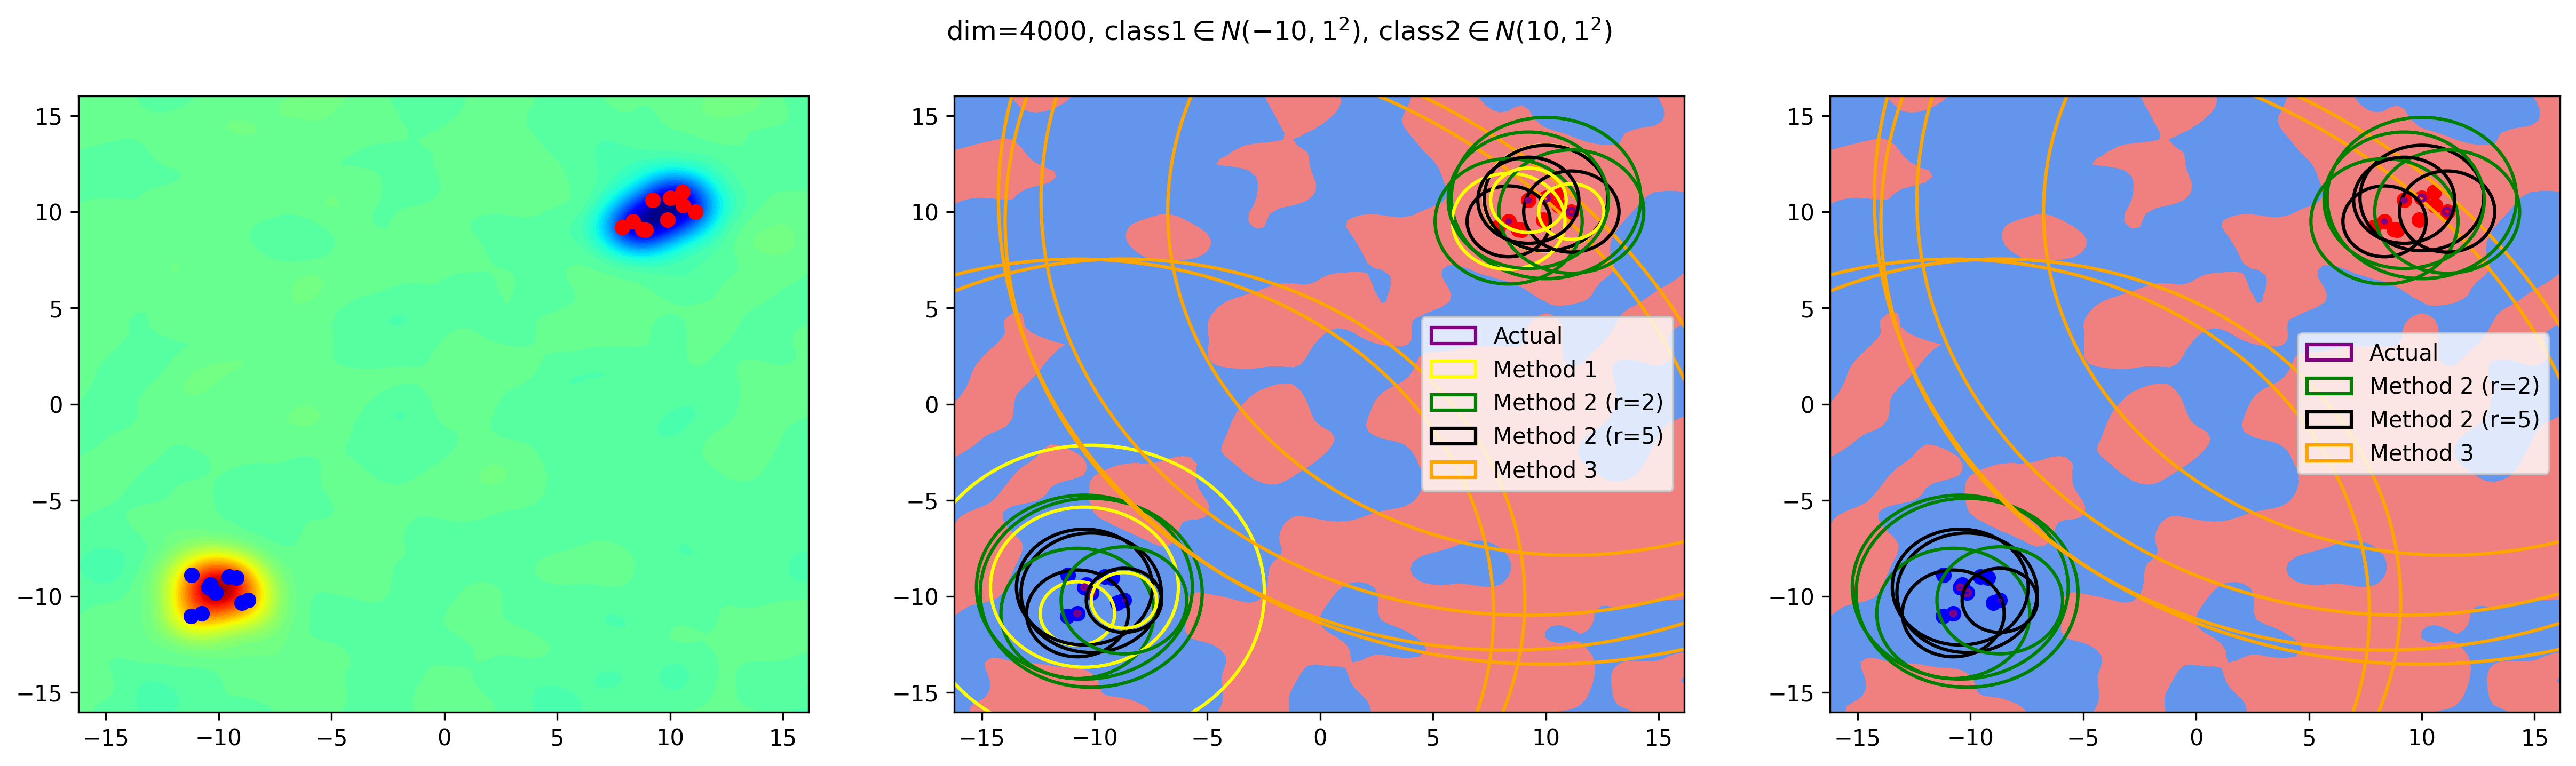

In [5]:
run_2d_test(original_dim, dim, -10, 10, 1, 1)

Method1 tensor(7247.1309)
Method1 (autograd) tensor(7247.1309)
Method2 tensor(36409.8828)
Method3 tensor(12741.1035)
Method3 (autograd) tensor(12741.1035)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55053/1852982673.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


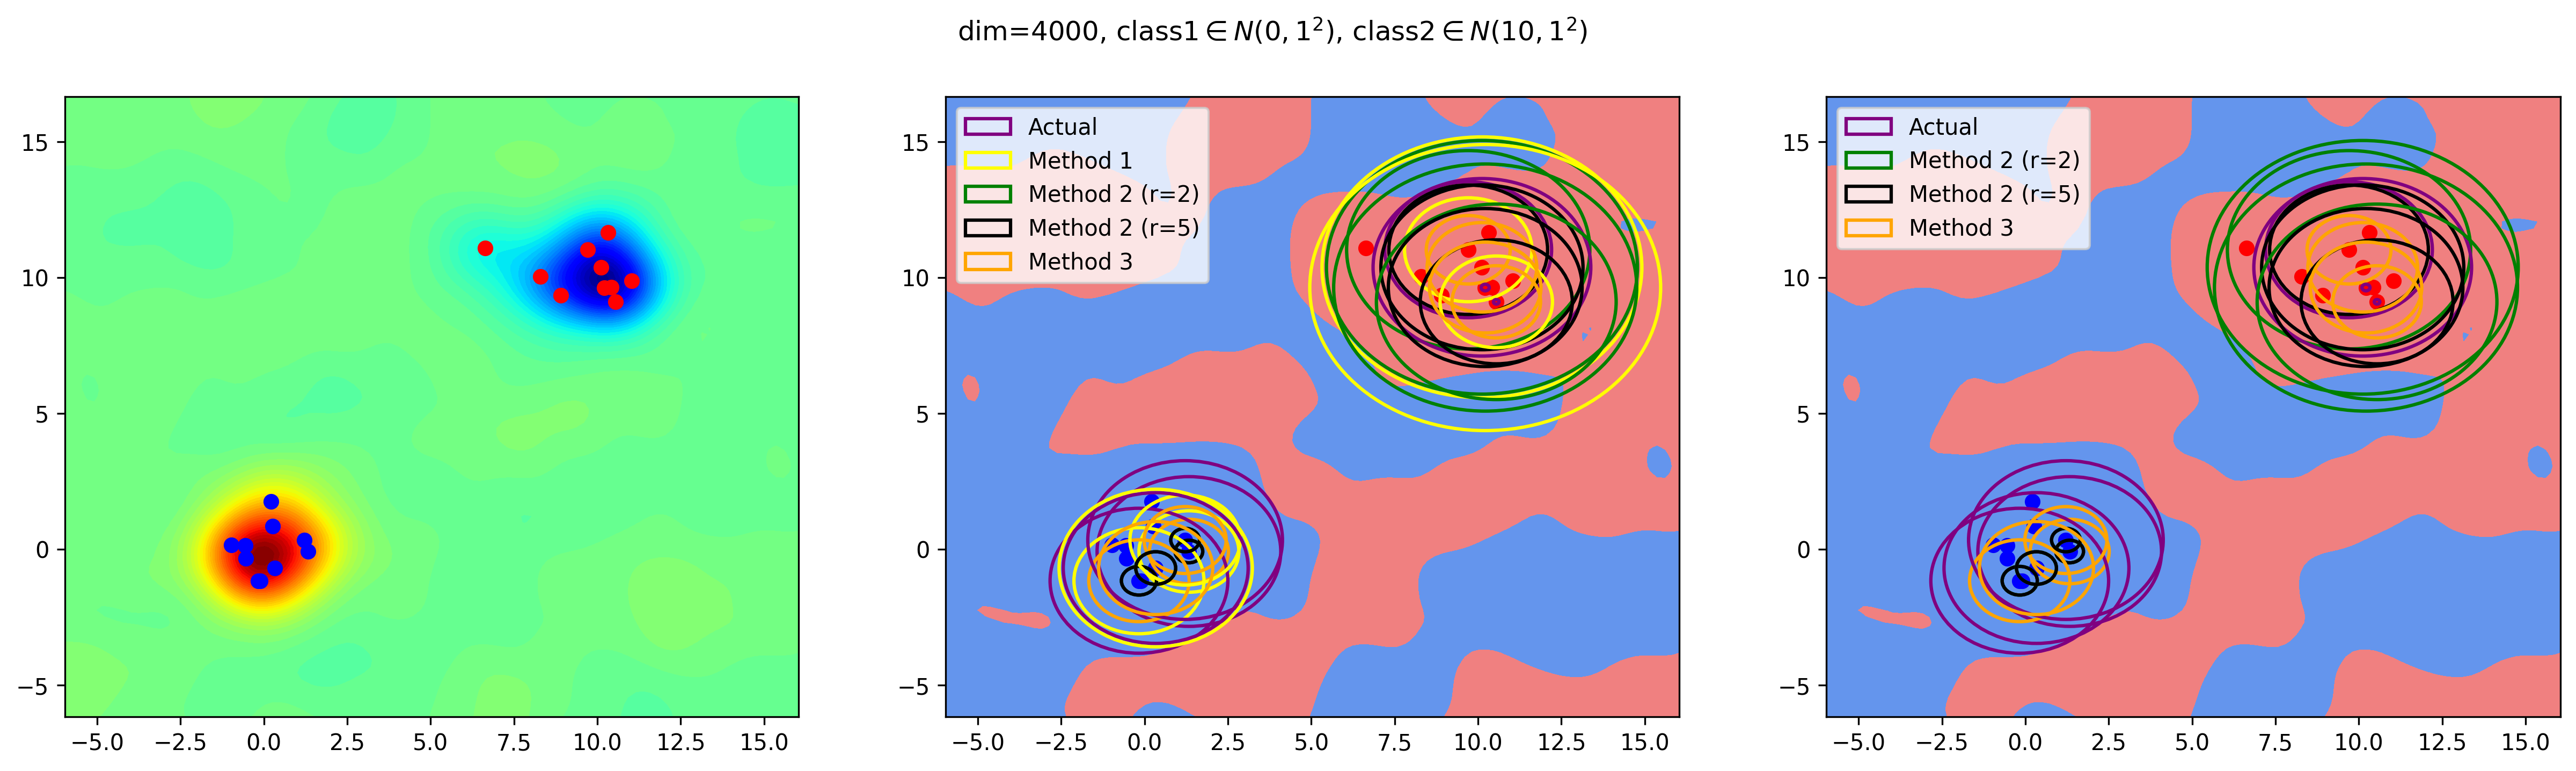

In [6]:
run_2d_test(original_dim, dim, 0, 10, 1, 1)

Method1 tensor(7273.7900)
Method1 (autograd) tensor(7273.7900)
Method2 tensor(32356.2266)
Method3 tensor(9946.7471)
Method3 (autograd) tensor(9946.7471)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55053/1852982673.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


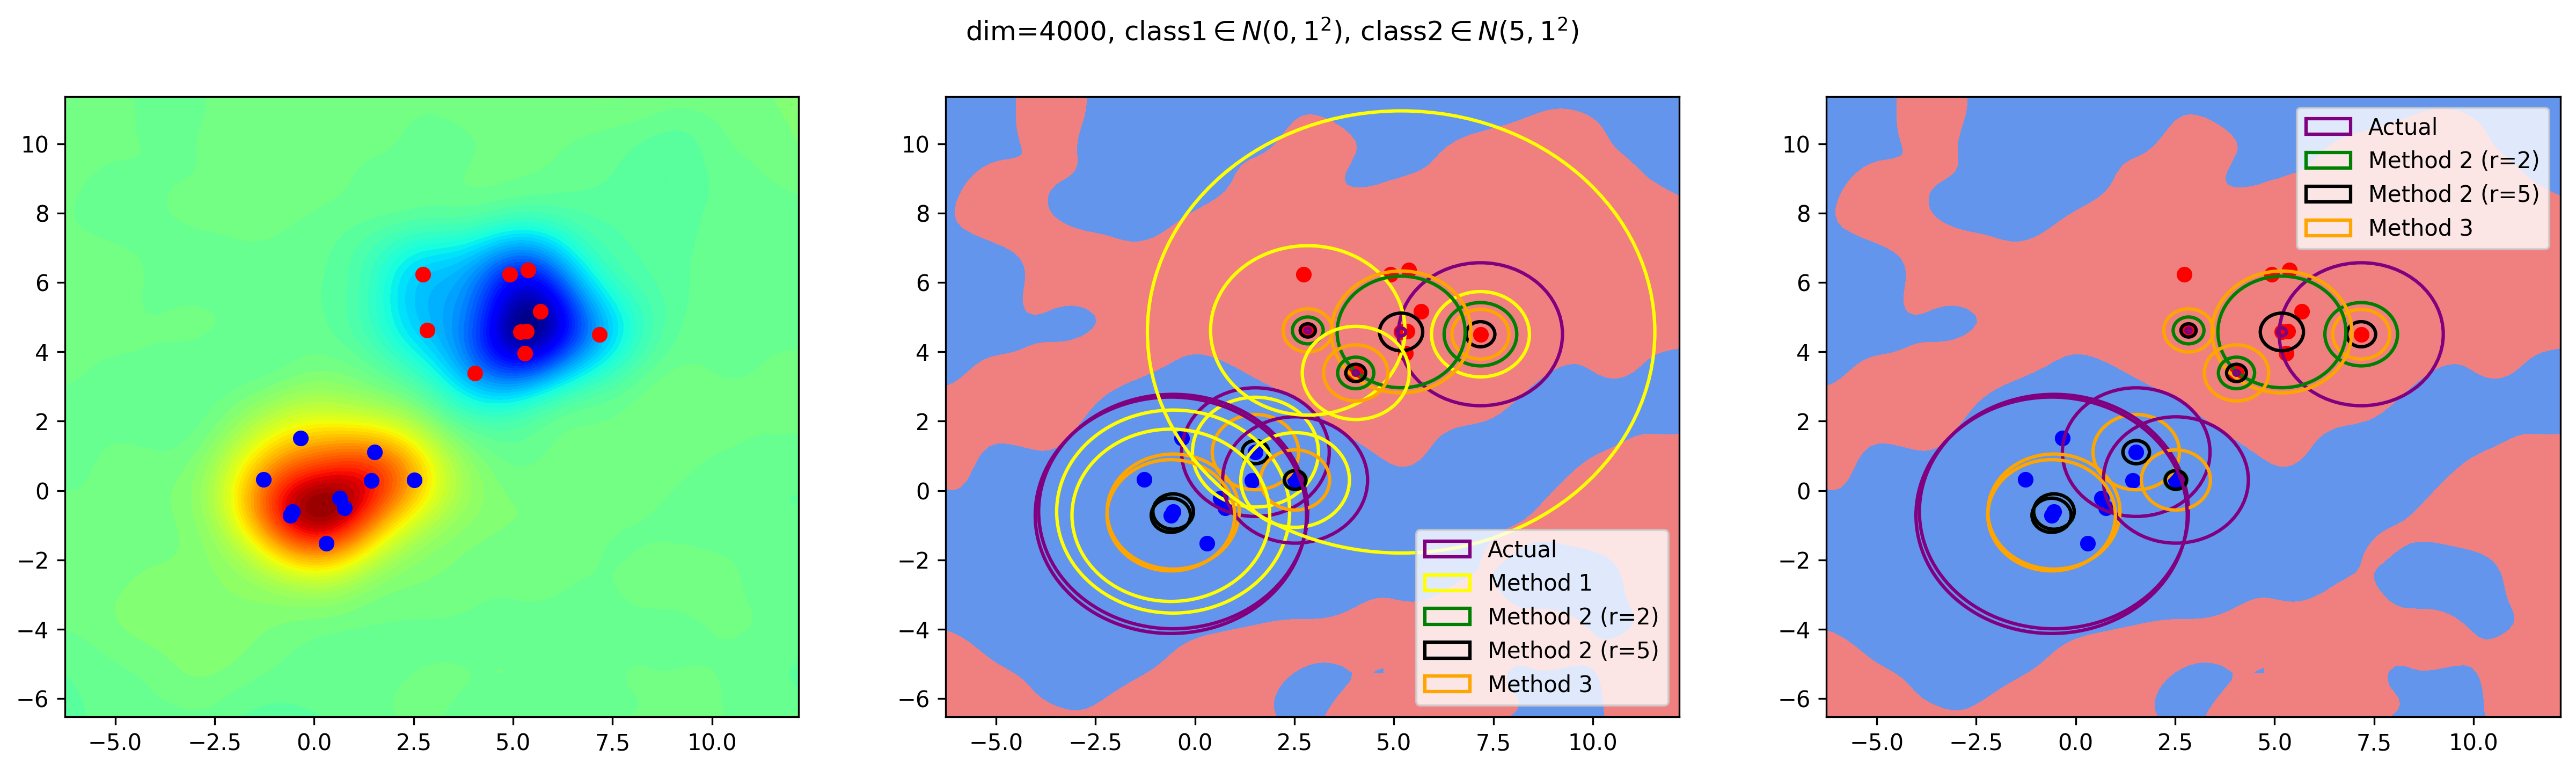

In [7]:
run_2d_test(original_dim, dim, 0, 5, 1, 1)

Method1 tensor(5757.6631)
Method1 (autograd) tensor(5757.6631)
Method2 tensor(32939.0703)
Method3 tensor(16479.1875)
Method3 (autograd) tensor(16479.1875)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55053/1852982673.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


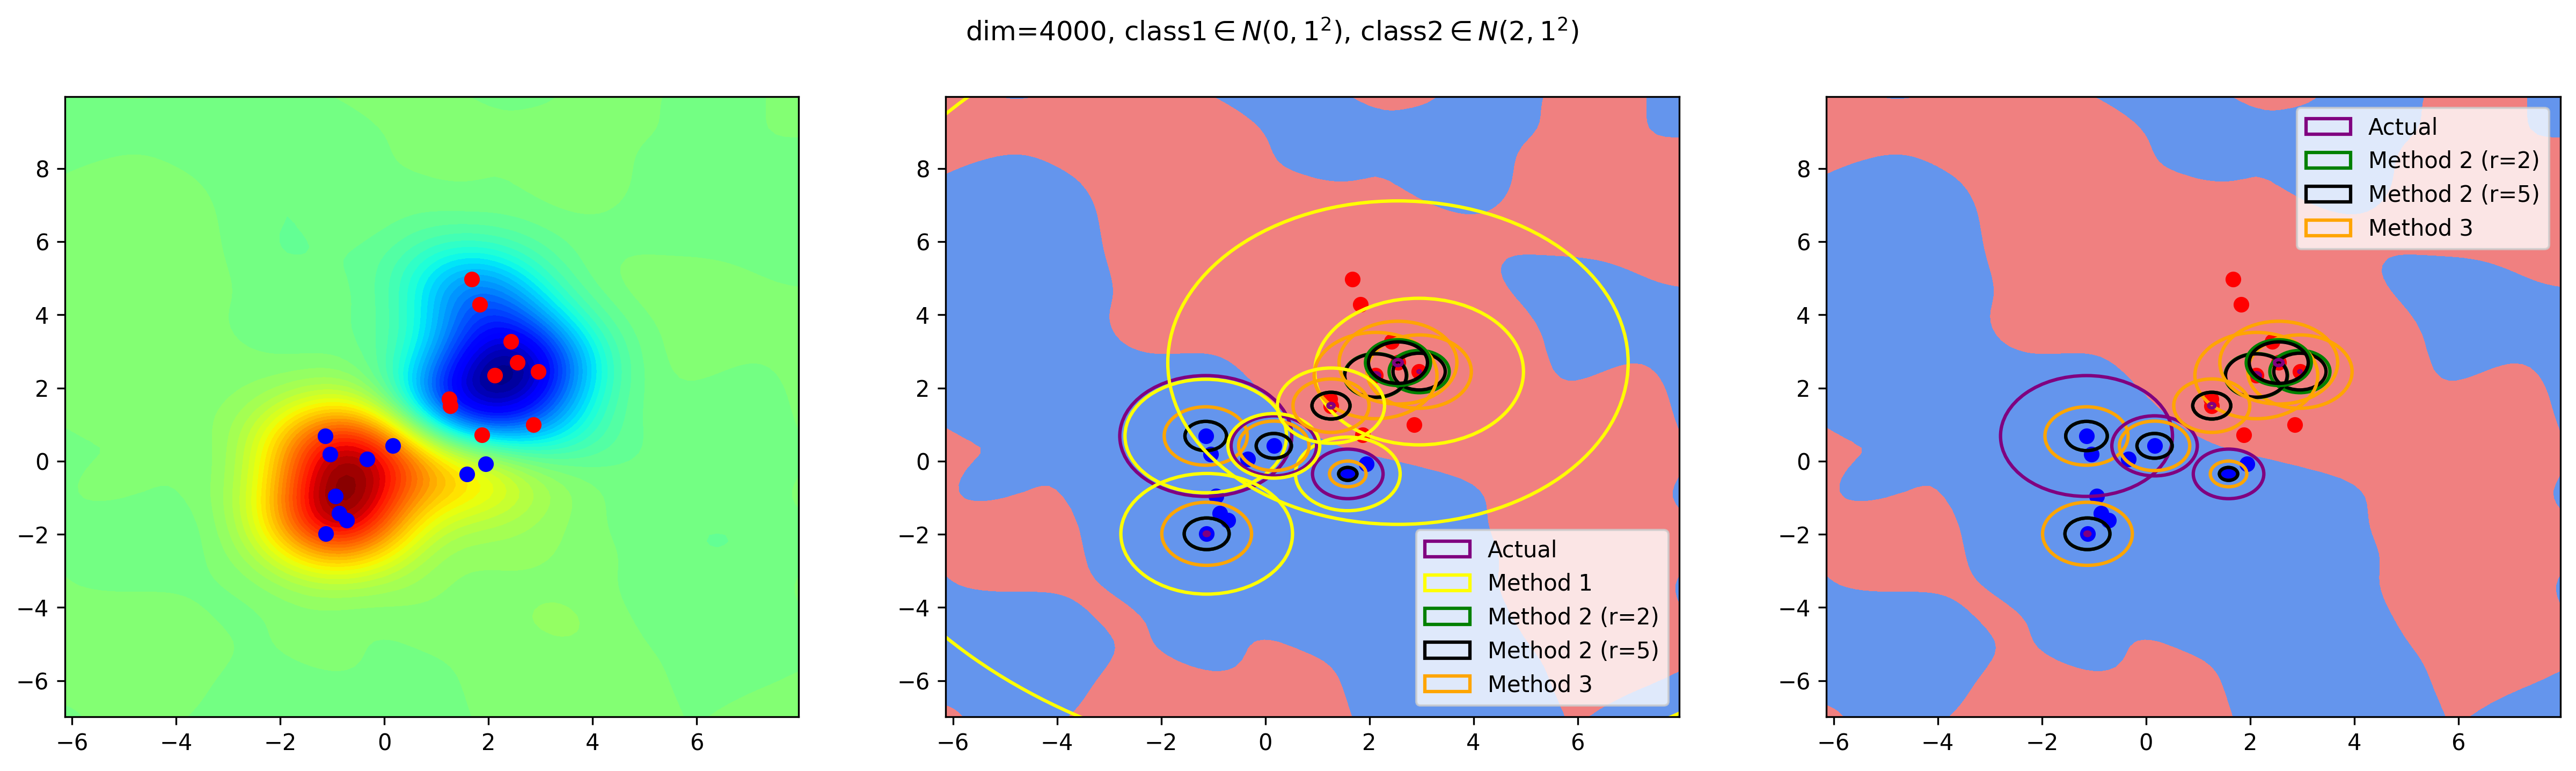

In [8]:
run_2d_test(original_dim, dim, 0, 2, 1, 1)

Method1 tensor(384.0820)
Method1 (autograd) tensor(384.0820)
Method2 tensor(2512.9297)
Method3 tensor(668.5544)
Method3 (autograd) tensor(668.5544)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55053/1852982673.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


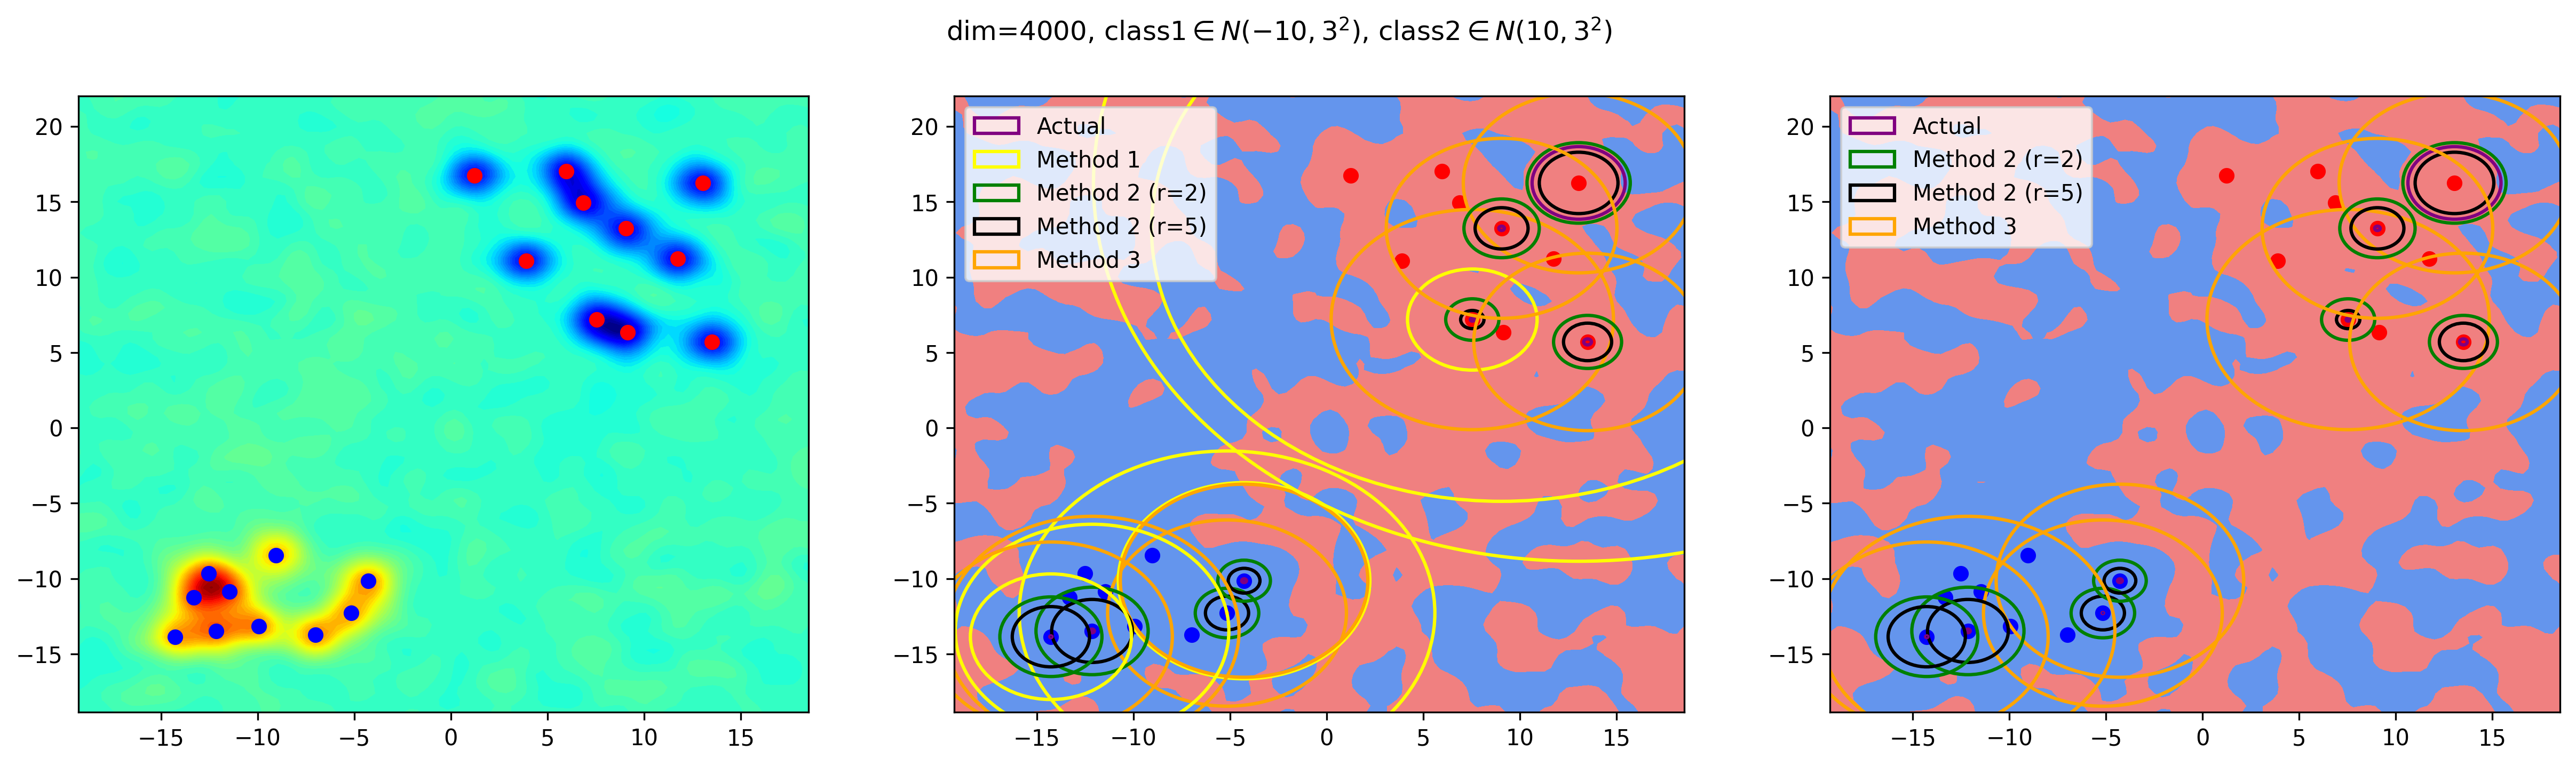

In [9]:
run_2d_test(original_dim, dim, -10, 10, 3, 3)

Method1 tensor(3075.4214)
Method1 (autograd) tensor(3075.4214)
Method2 tensor(17763.6895)
Method3 tensor(5300.9785)
Method3 (autograd) tensor(5300.9785)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55053/1852982673.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


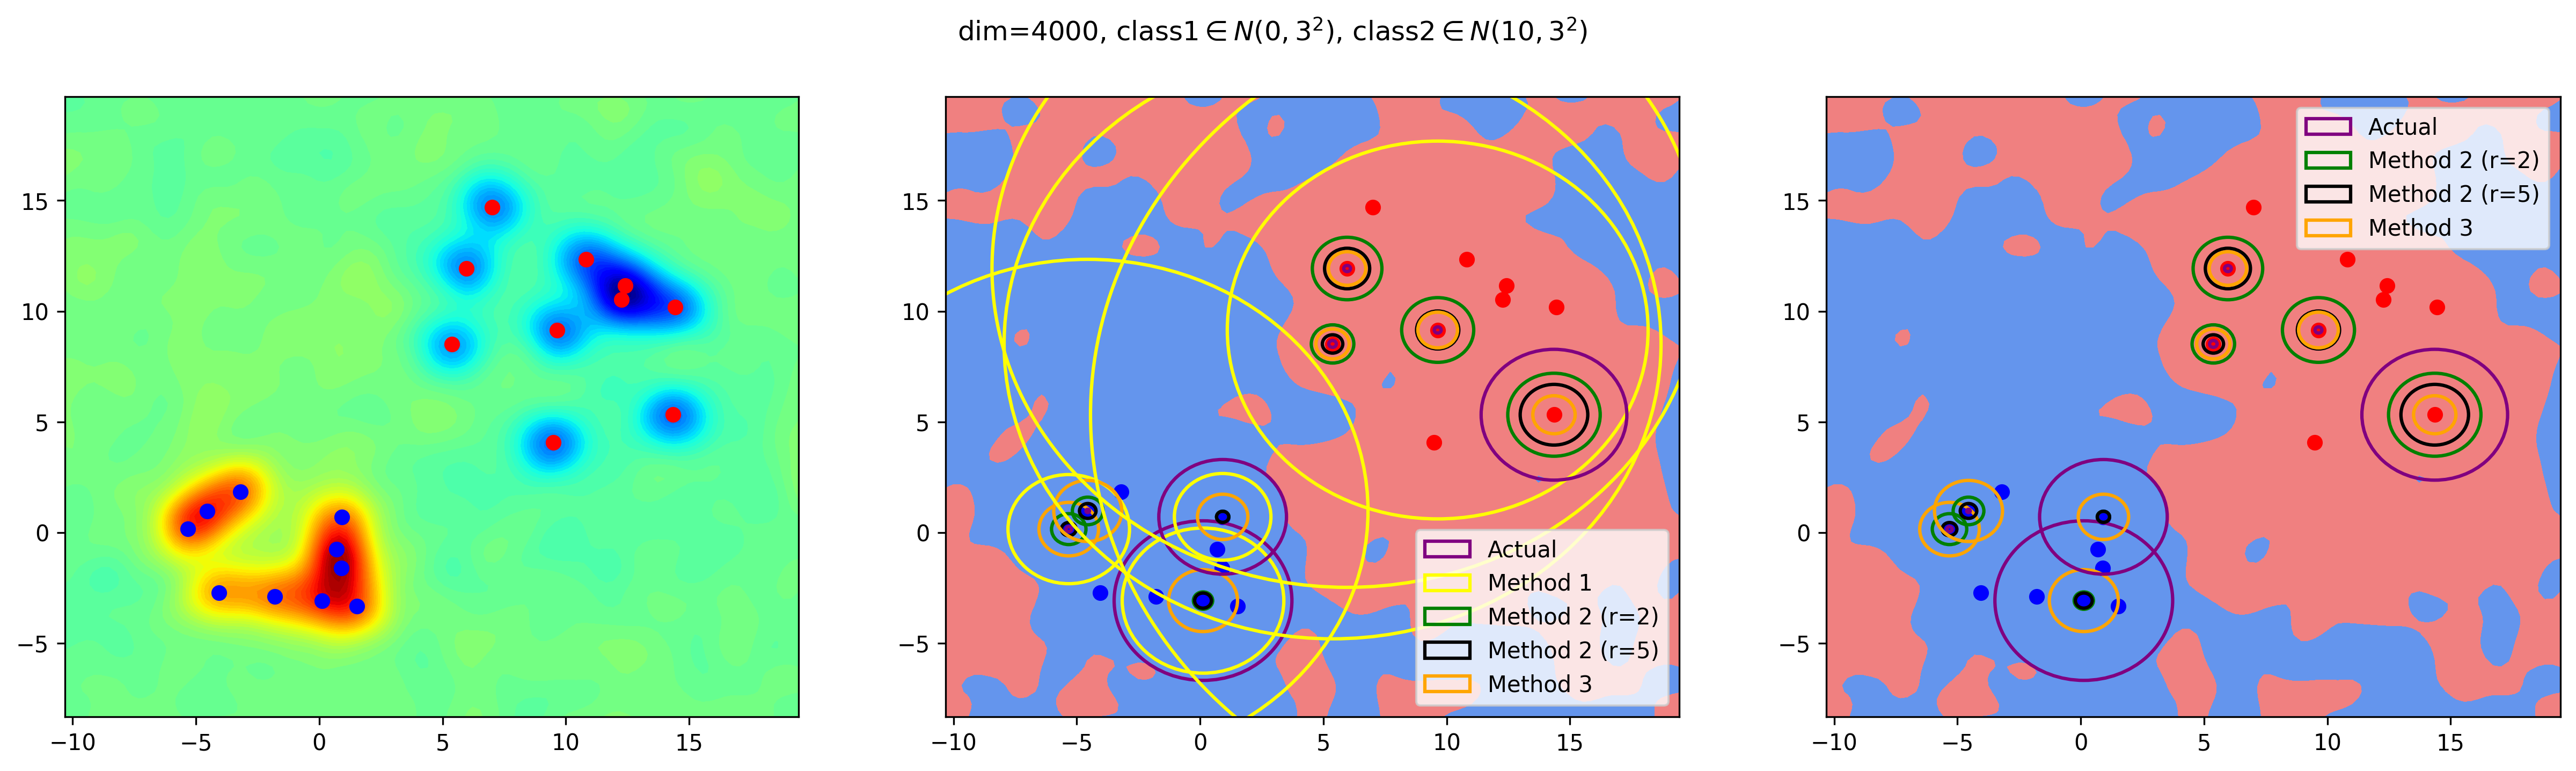

In [10]:
run_2d_test(original_dim, dim, 0, 10, 3, 3)

Method1 tensor(3669.2891)
Method1 (autograd) tensor(3669.2891)
Method2 tensor(8805.6553)
Method3 tensor(5091.2861)
Method3 (autograd) tensor(5091.2861)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55053/1852982673.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


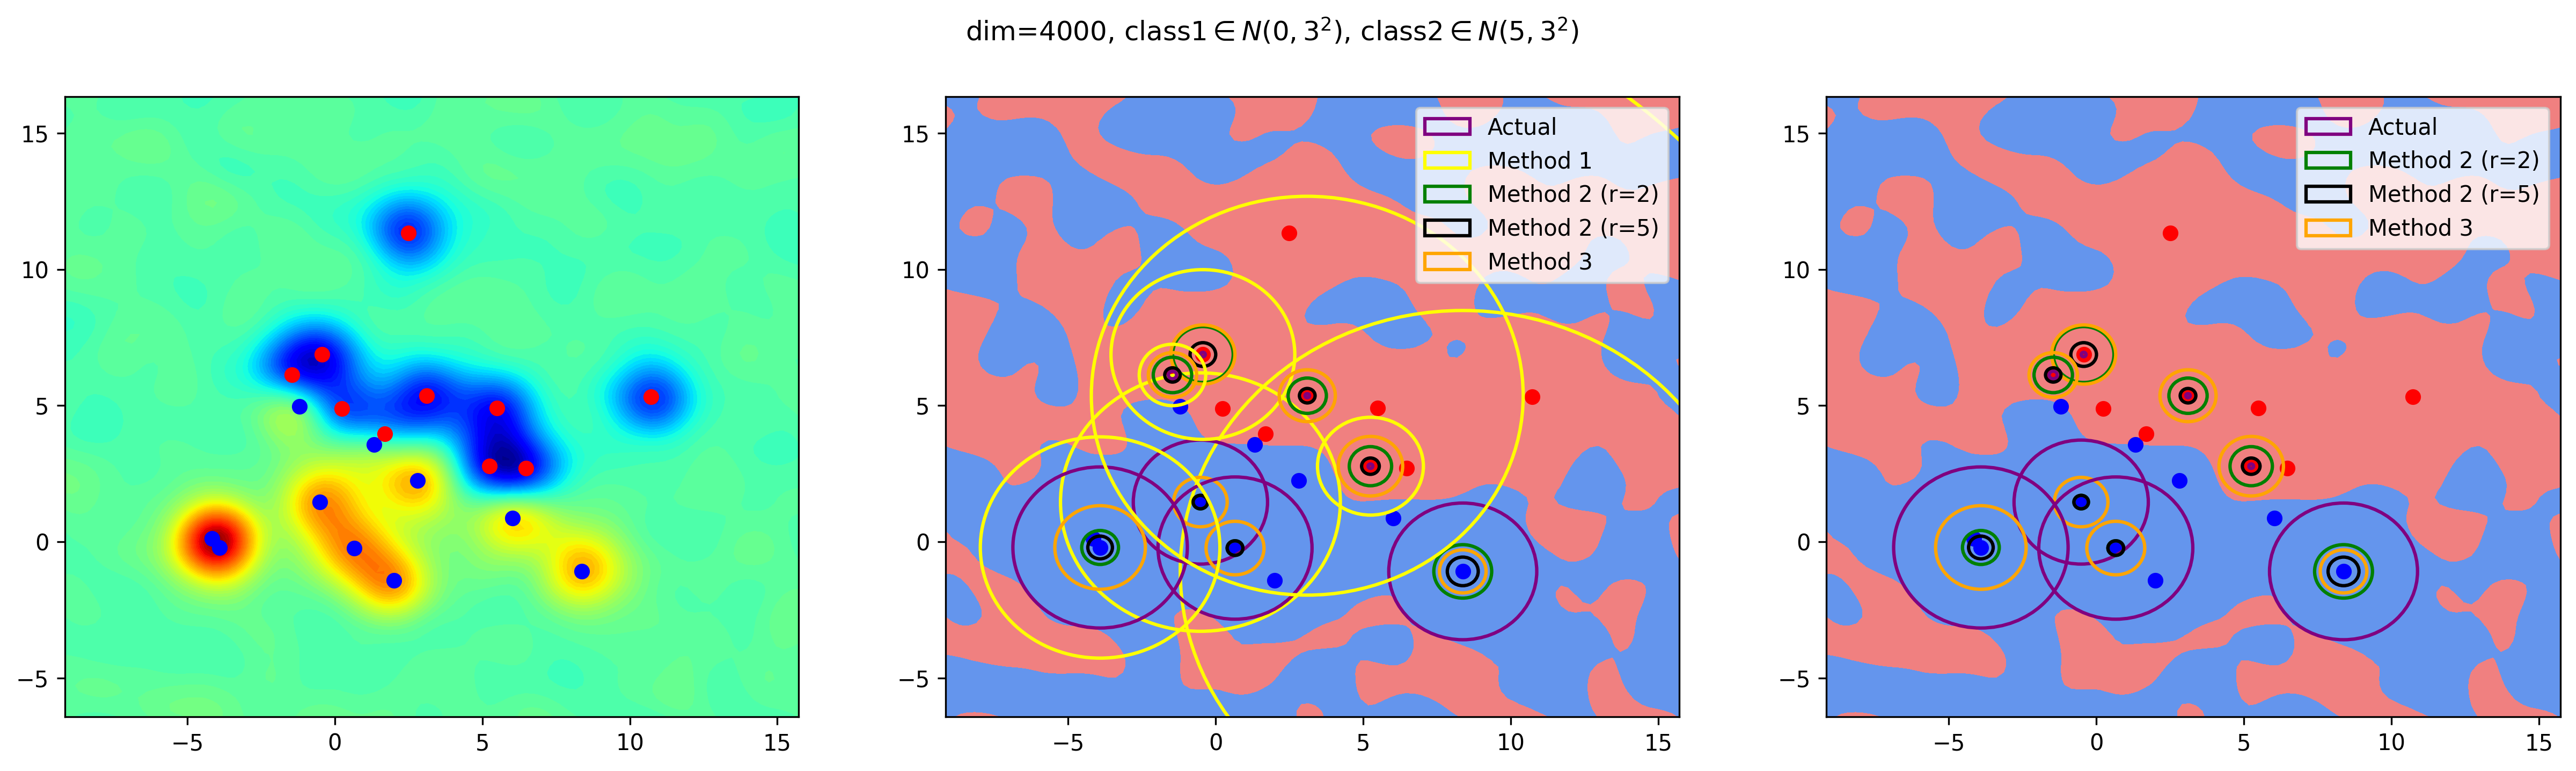

In [11]:
run_2d_test(original_dim, dim, 0, 5, 3, 3)

Method1 tensor(285.7220)
Method1 (autograd) tensor(285.7220)
Method2 tensor(4891.0010)
Method3 tensor(6509.7803)
Method3 (autograd) tensor(6509.7803)


/var/folders/0d/85ds7j1x59j1dwn1s6nph45m0000gn/T/ipykernel_55053/1852982673.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


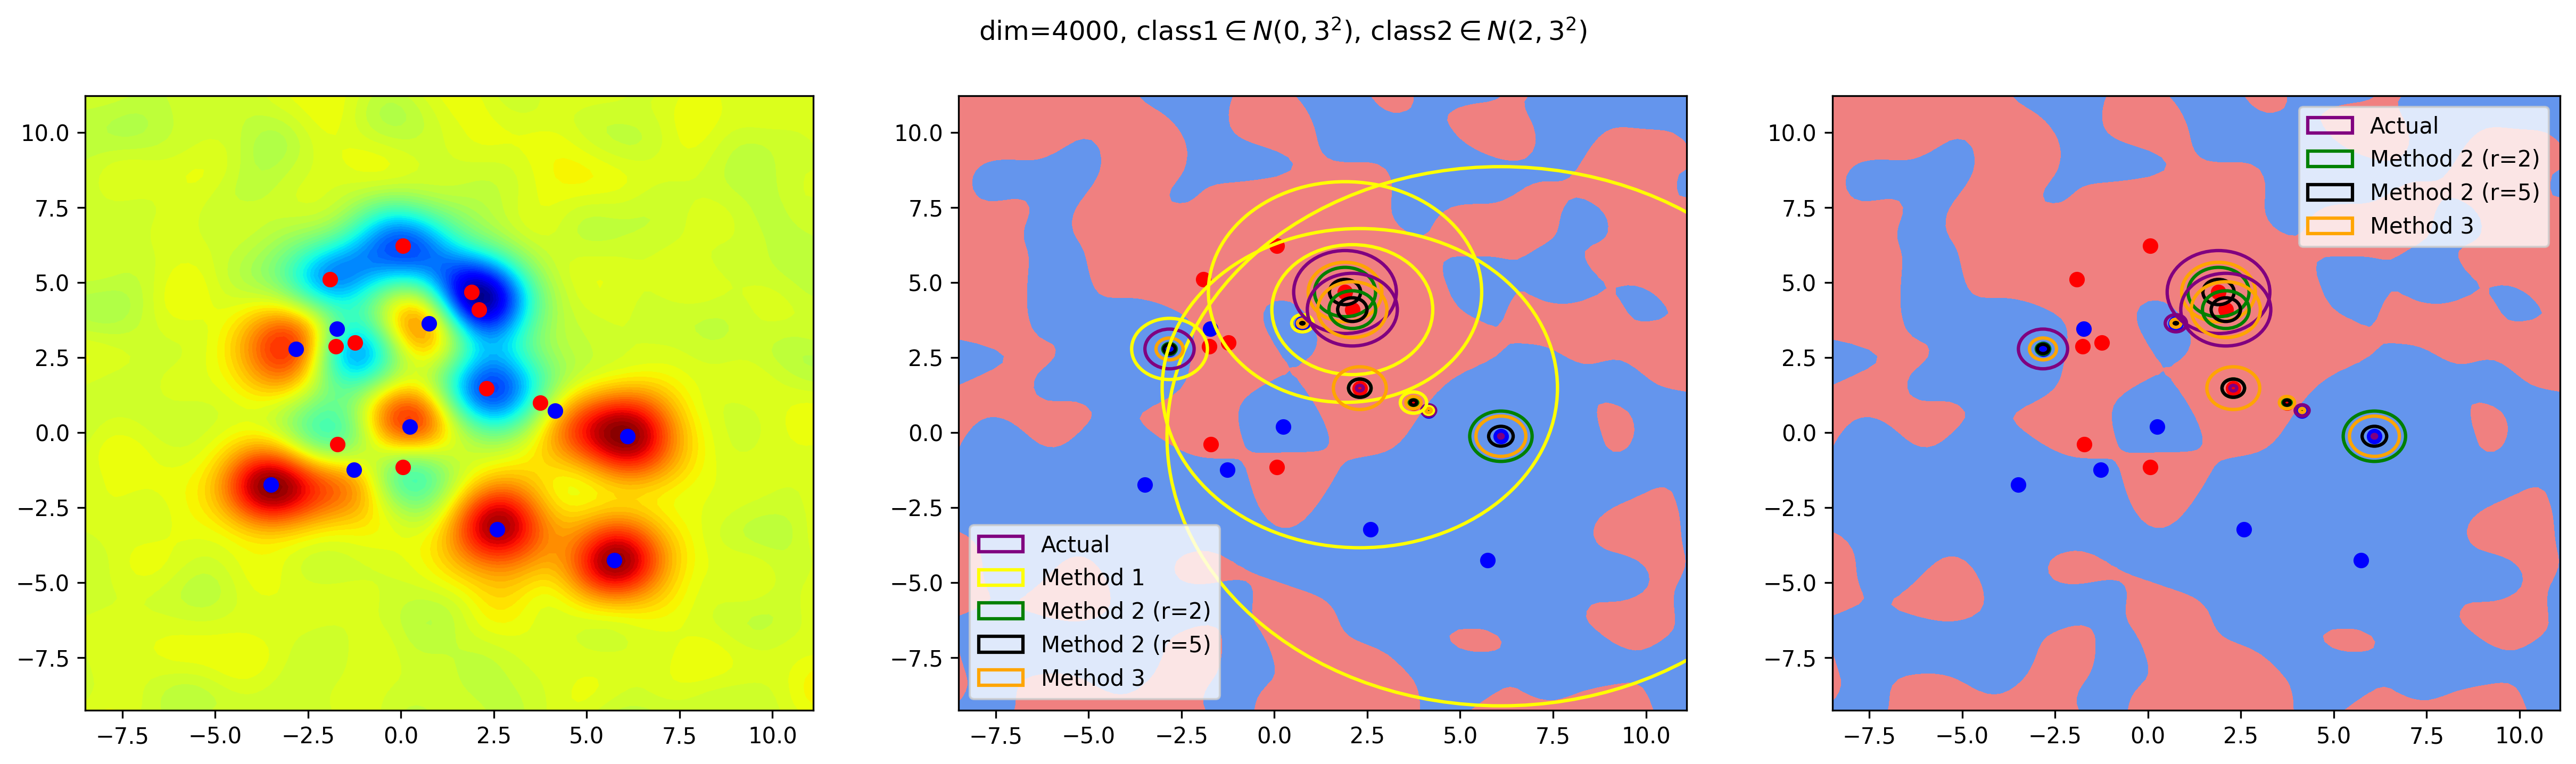

In [12]:
run_2d_test(original_dim, dim, 0, 2, 3, 3)